In [24]:
# Import libraries
import os
import sys
import subprocess
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pyfonts import set_default_font, load_google_font
import cmcrameri.cm as cmc
from landlab import RasterModelGrid
from landlab.components import LinearDiffuser
from landlab.components import FlowAccumulator, FastscapeEroder
import cv2

# Find GRASS Python packages
sys.path.append(
  subprocess.check_output(
    ["grass", "--config", "python_path"],
    text=True
    ).strip()
  )

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

# Create a temporary folder
import tempfile
temporary = tempfile.TemporaryDirectory()

# Create a project in the temporary directory
gs.create_project(path=temporary.name, name="landlab")

# Start GRASS in this project
session = gj.init(Path(temporary.name, "landlab"))
session = gj.init("landlab")
tools = Tools()

In [25]:
# Set region
rows = 200
cols = 800
resolution = 10
tools.g_region(s=0, w=0, n=rows * resolution, e=cols * resolution, res=resolution)

In [26]:
# Generate fractal terrain
fractal = tools.r_surf_fractal(output=np.array, seed=6)
fractal *= 0.1
fractal = np.abs(fractal)

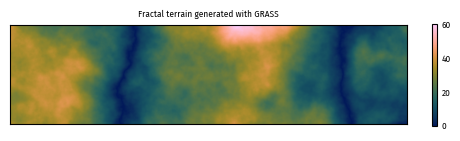

In [30]:
# Set font
font = load_google_font("Fira Sans")
set_default_font(font)

# Plot figure
figure = plt.figure()
ax = figure.add_subplot()
ax.set_title("Fractal terrain generated with GRASS", fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
image = ax.imshow(fractal, cmap=cmc.batlow)
ticks = [0, 20, 40, 60]
legend = figure.colorbar(image, shrink=0.275)
legend.set_ticks(ticks)
legend.ax.tick_params(size=0)
legend.ax.tick_params(labelsize=6)

# Save image
figure.savefig(
    "fractal.png",
    dpi=600,
    bbox_inches="tight",
)

In [21]:
# Erode terrain
grid = RasterModelGrid((rows, cols), xy_spacing=resolution)
grid.add_field("topographic__elevation", fractal.ravel(), at="node")
fa = FlowAccumulator(grid, flow_director="D8")
fsp = FastscapeEroder(grid, K_sp=0.01, m_sp=0.5, n_sp=1.0)
ld = LinearDiffuser(grid, linear_diffusivity=1)
for i in range(250):
    fa.run_one_step()
    fsp.run_one_step(dt=1.0)
    ld.run_one_step(dt=1.0)
erosion = grid.at_node['topographic__elevation'].reshape(grid.shape)

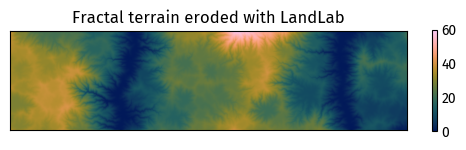

In [22]:
# Plot figure
figure = plt.figure()
ax = figure.add_subplot()
ax.set_title("Fractal terrain eroded with LandLab", fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
image = ax.imshow(erosion, cmap=cmc.batlow)
ticks = [0, 20, 40, 60]
legend = figure.colorbar(image, shrink=0.275)
legend.set_ticks(ticks)
legend.ax.tick_params(size=0)
legend.ax.tick_params(labelsize=6)

# Save image
figure.savefig(
    "erosion.png",
    dpi=600,
    bbox_inches="tight",
)

In [23]:
# Stack images
fractal = cv2.imread('fractal.png')
erosion = cv2.imread('erosion.png')
stacked = cv2.vconcat([fractal, erosion])
cv2.imwrite('figure_1.png', stacked)

True